<a href="https://colab.research.google.com/github/youssefHosni/Practical-Machine-Learning-Tips/blob/main/6_Tips_Save_Me_Time_%26_MemoryWhen_Training_Machine_Learning%C2%A0Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6 Tips Save Me Time & MemoryWhen Training Machine Learning Models


Training machine learning models can be time and memory consuming epically if your data is so large. However, usually, you will have to train multiple models or train the model multiple times with different hyperparameters to find the best hyperparameters for your model. Therefore it is important to be able to optimize your workflow so as to save as much computational time and memory consumption as possible to be able to find the best models and train them efficiently. 

In this article, I will share with you six practical tips that I personally use to decrease computational time and meomery consumption when I work on a data science project or train a machine learning model.

We will use the MNSIT dataset throughout this article and will apply all the tips on it and see how the results and the time and memory consumption were affected. Let's load the data and reshape it to be able to use with our models:

In [1]:
# load all the packages and the libraries that will be used
from sklearn.decomposition import PCA
from matplotlib import pyplot
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import time

11490434/11490434 [==============================] - 0s 0us/step


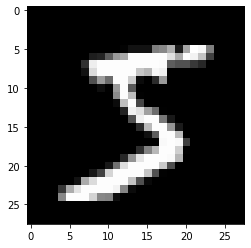

In [2]:
# Loading and Plotting random image of the mnsit dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# plotting the first image of the MNSIt dataset
pyplot.imshow(train_X[0], cmap=pyplot.get_cmap('gray'))
pyplot.show()

Now, let's print the shape of the data:

In [3]:
print('The shape of the train data',train_X.shape)

print('The shape of the test data',test_X.shape)


The shape of the train data (60000, 28, 28)
The shape of the test data (10000, 28, 28)


Finally, let's reshape the data to be able to apply the dimensionality reduction algorithms to it:

In [4]:
train_X_reshaped = train_X.reshape(train_X.shape[0], 28*28)
print('The shape of the reshaped train data', train_X_reshaped.shape)

test_X_reshaped = test_X.reshape(test_X.shape[0], 28*28)
print('The shape of the reshaped test data', test_X_reshaped.shape)


The shape of the reshaped train data (60000, 784)
The shape of the reshaped test data (10000, 784)


# Table of Content:

1.   Train on All The CPU Cores
2.   Use Randomized PCA
3. Use Incremental PCA
4. Apply Chain Rule
5. Use Linear SVM
6. Use Mini-Batch K-Means



#1. Train on All The CPU cores

Bagging and posting are learning approaches in which we use the same training algorithm for every predictor but train them on different random subsets of the training set. 

When sampling is performed with replacement, this method is called bagging (short for bootstrap aggregating). When sampling is performed without replacement, it is called pasting.

In other words, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor.

One of the main reasons bagging and pasting are famous, besides their good results, is that they can scale very well in an easy way. Since the predictor can be trained in parallel as they are independent, you can train on multiple CPU cores or on multiple servers. The same can also be done in prediction.

Scikit learn offers a simple API for bagging and pasting with the BaggingClassifier class. The parameter n_jobs defines the number of cores that can be used in both training and prediction. The code below n_jobs = -1, meaning use all the available cores.

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


# get the start time
st = time.time()

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), 
    n_estimators=500,
    max_samples=100, 
    bootstrap=True)

bag_clf.fit(train_X_reshaped, train_y)

y_pred = bag_clf.predict(test_X_reshaped)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')


Execution time: 135.00484466552734 seconds


In [6]:
# get the start time
st = time.time()


bag_clf_all_cores = BaggingClassifier(
    DecisionTreeClassifier(), 
    n_estimators=500,
    max_samples=100, 
    bootstrap=True,
    n_jobs = -1)

bag_clf_all_cores.fit(train_X_reshaped, train_y)

y_pred = bag_clf_all_cores.predict(test_X_reshaped)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')


Execution time: 122.92714071273804 seconds


As you can see using all the CPU cores decreased the computational time by at least 4 folds.

# 2. Use Randomized PCA

If you would like to increase the speed of PCA you can set the svd_solver hyperparameter to "randomized" in Scikit-Learn. This will make it use a stochastic algorithm called Randomized PCA that quickly finds an approximation of the first d principal components. 

Its computational complexity is O(m × d2) + O(d3), instead of O(m × n2) + O(n3) for the full SVD approach, so it is dramatically faster than full SVD when d is much smaller than n:

In [7]:
# Calculate the execution time for the PCA using full SVD solver

# get the start time
st = time.time()

rnd_pca = PCA(n_components=100, svd_solver="full")
X_reduced_rand = rnd_pca.fit_transform(train_X_reshaped)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time using full SVD', elapsed_time, 'seconds')

Execution time using full SVD 12.036218404769897 seconds


In [8]:
# Calculate the execution time for the PCA using randomized solver

# get the start time
st = time.time()

rnd_pca = PCA(n_components=100, svd_solver="randomized")
X_reduced_rand = rnd_pca.fit_transform(train_X_reshaped)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time using randomized solver', elapsed_time, 'seconds')

Execution time using randomized solver 6.658643960952759 seconds


By default, svd_solver is actually set to "auto": Scikit-Learn automatically uses the randomized PCA algorithm if m or n is greater than 500 and d is less than 80% of m or n, or else it uses the full SVD approach. If you want to force Scikit-Learn to use full SVD, you can set the svd_solver hyperparameter to "full".

#3. Incremental PCA

If you would like to apply PCA to a large dataset you will probably face a memory error since the implementations of PCA requires the whole training set to fit in memory in order for the algorithm to run.

Fortunately, 𝗜𝗻𝗰𝗿𝗲𝗺𝗲𝗻𝘁𝗮𝗹 𝗣𝗖𝗔 (𝗜𝗣𝗖𝗔) algorithms have been developed to solve this problem: you can split the training set into mini-batches and feed an IPCA algorithm one mini-batch at a time. This is useful for large training sets, and also to apply PCA online.

The following code splits the training dataset into 100 mini-batches (using NumPy's array_split() function) and feeds them to Scikit-Learn's IncrementalPCA class to reduce the dimensionality of the training dataset down to 100 dimensions. Note that you must call the partial_fit() method with each mini-batch rather than the fit() method with the whole training set:

In [9]:
from sklearn.decomposition import IncrementalPCA
n_batches = 100

# Calculate the execution time for the PCA using randomized solver

# get the start time
st = time.time()


inc_pca = IncrementalPCA(n_components=100)
for X_batch in np.array_split(train_X_reshaped, n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(train_X_reshaped)

#get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time using incremental PCA', elapsed_time, 'seconds')

Execution time using incremental PCA 34.422614097595215 seconds


This will be very useful if your data is very large that it will not fit in the memory. However it will increase the computational time compared to the traditional PCA, so you should use it only if your data is so large that it does not fit in the meomery.

#4. Use Chain Rule

If you would like to use a very slow dimension reduction method especially if your data is nonlinear such as Locally Linear Embedding (LLE) or t-distributed stochastic neighbor embedding (t-DSNE) you can chain two dimension reduction algorithms to decrease the computational time of the LLE and still have almost the same result. 

First, you apply a faster dimensionality reduction algorithm on the whole data to reduce the dimension into a lower one and then apply a slower one to reduce the rest with higher quality. This always works as both dimension reductions will have a similar effect on the higher dimensions. 

You can first apply PCA to your data to quickly get rid of a large number of useless dimensions and then use LLE. This will yield a similar performance as just using LLE but in a fraction of its time.
Let's first apply LLE to the dataset to reduce a subset of the MNSIT dataset and reduce the data to 2 components:

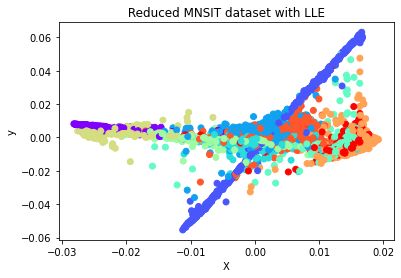

Execution time using incremental PCA 13.673588514328003 seconds


In [25]:
from sklearn.manifold import LocallyLinearEmbedding

# Calculate the execution time for the PCA using randomized solver
# get the start time
st = time.time()

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced_LLE = lle.fit_transform(train_X_reshaped[0:5000,:])

plt.scatter(X_reduced_LLE[:, 0],X_reduced_LLE[:,1], c=train_y[0:5000], cmap=plt.cm.rainbow )
plt.xlabel("X") 
plt.ylabel("y")
plt.title(" Reduced MNSIT dataset with LLE ")
plt.show()

#get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time using incremental PCA', elapsed_time, 'seconds')

We can see that the time needed to reduce the data to 2 dimensions using LLE is 15 seconds. Now let's apply the chain rule in which you will first apply PCA to the MNSIT data and reduce it to 100 dimensions then apply LLE to this reduced data to reduce the dimension to 2 components only.

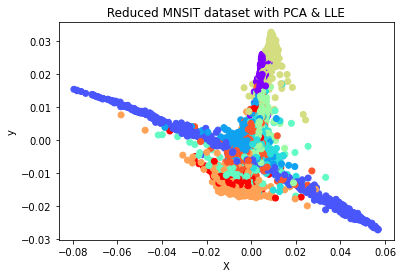

Execution time using incremental PCA 20.560760498046875 seconds


In [26]:
from sklearn.manifold import LocallyLinearEmbedding

# Calculate the execution time for the PCA using randomized solver
# get the start time
st = time.time()

rnd_pca = PCA(n_components=100, svd_solver="randomized")
X_reduced_rand = rnd_pca.fit_transform(train_X_reshaped[0:5000,:])

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced_LLE = lle.fit_transform(X_reduced_rand)

plt.scatter(X_reduced_LLE[:, 0],X_reduced_LLE[:,1], c=train_y[0:5000], cmap=plt.cm.rainbow )
plt.xlabel("X") 
plt.ylabel("y")
plt.title(" Reduced MNSIT dataset with PCA & LLE ")
plt.show()

#get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time using incremental PCA', elapsed_time, 'seconds')

As you can see both approaches resulted in similar  results but the second approach is must faster than the first one. Also, it is important to mention that I only applied these two methods on a small subset of the data and there is a difference of 4 seconds as the data size increases the time difference will increase and will show more of the advantage of applying this trick.

# 5. Use Linear SVM

Since 𝐋𝐢𝐧𝐞𝐚𝐫𝐒𝐕𝐂 class is based on the 𝐥𝐢𝐛𝐥𝐢𝐧𝐞𝐚𝐫 library, which implements an optimized algorithm for linear SVMs. It does not support the kernel trick, but it 𝐬𝐜𝐚𝐥𝐞𝐬 𝐚𝐥𝐦𝐨𝐬𝐭 𝐥𝐢𝐧𝐞𝐚𝐫𝐥𝐲 with the number of training instances and the number of features: its training time complexity is roughly O(m × n).

The algorithm takes longer if you require very high precision. This is controlled by the tolerance hyperparameter ϵ (called 𝐭𝐨𝐥 in 𝐒𝐜𝐢𝐤𝐢𝐭-𝐋𝐞𝐚𝐫𝐧). In most classification tasks, the default tolerance is fine. This will be a perfect choice if you have a large dataset but are linearly separable.

On the other hand, the 𝐒𝐕𝐂 class is based on the 𝐥𝐢𝐛𝐬𝐯𝐦 library, which implements an algorithm that supports the kernel trick. The training time complexity is usually between O(m2 × n) and O(m3 × n). Unfortunately, this means that it gets very slow when the number of training instances gets large (e.g., hundreds of thousands of instances).

This algorithm is perfect for 𝐜𝐨𝐦𝐩𝐥𝐞𝐱 𝐛𝐮𝐭 𝐬𝐦𝐚𝐥𝐥 𝐨𝐫 𝐦𝐞𝐝𝐢𝐮𝐦 𝐭𝐫𝐚𝐢𝐧𝐢𝐧𝐠 𝐬𝐞𝐭𝐬. However, it scales well with the number of features, especially with sparse features (i.e., when each instance has few nonzero features). In this case, the algorithm scales roughly with the average number of nonzero features per instance.
Let's try this on the MNSIT dataset and see the difference in computational time. First, we will train the linearSVC model on the MNSIT dataset and calculate the training and inference time:

In [6]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


# Calculate the execution time for the PCA using randomized solver
# get the start time
st = time.time()

svm_clf = Pipeline([
("scaler", StandardScaler()),
("linear_svc", LinearSVC(C=1, loss="hinge")),
])

svm_clf.fit(train_X_reshaped, train_y)

y_train_predict = svm_clf.predict(train_X_reshaped)
print('Train accuarcy of linear SVC', accuracy_score(train_y, y_train_predict, normalize=True))


#get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Training time using Linear SVC', elapsed_time, 'seconds')

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Train accuarcy of linear SVC 0.9302166666666667
Training time using Linear SVC 565.6794822216034 seconds


The training accuracy is 93% and the training computational time is 565 seconds. Let's see the test accuracy and the inference time:

In [7]:

# Calculate the execution time for the PCA using randomized solver
# get the start time
st = time.time()

y_test_predict = svm_clf.predict(test_X_reshaped)
print('Test accuarcy of linear SVC', accuracy_score(test_y, y_test_predict, normalize=True))

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Inference time using Linear SVC', elapsed_time, 'seconds')

Test accuarcy of linear SVC 0.9172
Inference time using Linear SVC 0.07637166976928711 seconds


The test accuracy of the LinearSVC classifier is 91% and the inference computation time is 0.07 seconds which is very small.
 
Now let's compare this to the kernel SVC classifier:

In [8]:
from sklearn.svm import SVC

# Calculate the execution time for the PCA using randomized solver
# get the start time
st = time.time()


poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(train_X_reshaped, train_y)

y_train_predict = poly_kernel_svm_clf.predict(train_X_reshaped)
print('Train accuarcy of  SVC', accuracy_score(train_y, y_train_predict, normalize=True))

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Training time using Kerenl SVC', elapsed_time, 'seconds')

Train accuarcy of  SVC 0.9995833333333334
Training time using Kerenl SVC 679.7353920936584 seconds


The training accuracy is 99% which is much higher than the linaerSVC, however, the computational time is 679 seconds which is also more than that of the LinearSVC classifier. 

Finally, let's compare the test accuracy and the inference computational time of the kernel SVC classifier with the LinearSVC:

In [9]:
from sklearn.metrics import accuracy_score

# get the start time
st = time.time()

y_test_predict = poly_kernel_svm_clf.predict(test_X_reshaped)
print('Test accuarcy of  SVC', accuracy_score(test_y, y_test_predict, normalize=True))

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Inference time using Kerenl SVC', elapsed_time, 'seconds')

Test accuarcy of  SVC 0.9769
Inference time using Kerenl SVC 78.81518244743347 seconds


The test accuracy is 97% which is again much higher than the test accuracy of the LinearSVC classifier. The computational time during inference is 78.85 seconds which is 100 times more compared to the LinearSVC inference computational time. 

In conclusion, the performance of the kernel SVC classifier is higher than Linear SVC but the computational time especially the inference computational time is much higher than the LinearSVC.

#6. Use Mini-Batch K-Means

If you would like to apply the K_Means algorithm to a large dataset you can use MiniBatchKmeans class. Instead of using the full dataset at each iteration, the algorithm is capable of using mini-batches, moving the centroids just slightly at each iteration. This speeds up the algorithm typically by a factor of 3 or 4 and makes it possible to cluster huge datasets that do not fit in memory.

Scikit-Learn implements this algorithm in the MiniBatchKMeans class. You can just use this class like the KMeans class. Let's apply this to the MNSIT dataset and cluster it into nine clusters and calculate the computational time and compare it to the K-Means algorithm:

In [23]:
from sklearn.cluster import MiniBatchKMeans

# get the start time
st = time.time()

minibatch_kmeans = MiniBatchKMeans(n_clusters=9)
minibatch_kmeans.fit(train_X_reshaped)

# get the end time
et = time.time()


# get the execution time
elapsed_time = et - st
print('Computaional time using MiniBatch K-Means', elapsed_time, 'seconds')

Computaional time using MiniBatch K-Means 1.9091169834136963 seconds


The computational time for clustering the data using MiniBatchKMeans is 1.9 seconds. Let's compare this to the K-Means clustering algorithm:

In [24]:
from sklearn.cluster import KMeans

# get the start time
st = time.time()

kmeans = KMeans(n_clusters=9)
kmeans.fit(train_X_reshaped)

# get the end time
et = time.time()


# get the execution time
elapsed_time = et - st
print('Computaional time using K-Means', elapsed_time, 'seconds')

Computaional time using K-Means 65.53211736679077 seconds


The computational time for clustering the data using K-Means is 65.53 seconds which is 50 times more than the computational time of the MiniBatchKMeans clustering algorithm.